## Movie Data Analysis

## Goal of Analysis: Use machine learning algorithms to get a highly accurate prediction for how popular a movie will be given the attributes in the TMDB 5000 Movies Dataset.

In [126]:
# Imports
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [127]:
# Load the TMDB 5000 Movies Dataset
df = pd.read_csv('tmdb_5000_movies.csv')

## Data Exploration

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [129]:
df.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


## Data Cleaning

In [130]:
# Create a copy of the original DataFrame for cleaning
df_clean = df.copy()

In [131]:
# Drop unnecessary columns
columns_to_drop = ['homepage', 'id', 'original_title', 'release_date', 'status', 'spoken_languages']
df_clean.drop(columns=columns_to_drop, inplace=True)

In [132]:
# Handle null values

# runtime has only 2 missing values, so replace null values with median value
median_runtime = df_clean['runtime'].median()
df_clean['runtime'].fillna(median_runtime, inplace=True)

In [133]:
# Perform log transformation for positively-skewed attributes
df_clean['budget'] = np.log1p(df_clean['budget'])
df_clean['popularity'] = np.log1p(df_clean['popularity'])
df_clean['revenue'] = np.log1p(df_clean['revenue'])
df_clean['vote_count'] = np.log1p(df_clean['vote_count'])

In [134]:
# Account for multicollinearity
df_clean.drop('vote_count', axis=1, inplace=True) # vote_count and popularity highly correlated, drop vote_count

df_clean['revenue_budget_ratio'] = np.where( # revenue and budget highly correlated, perform feature engineering
    (df['budget'] != 0) & (df['revenue'] != 0), # if revenue and budget are both nonzero
    df['revenue'] / df['budget'], # calculate the revenue to budget ratio
    0  # else, replace with 0
)
df_clean.drop('revenue', axis=1, inplace=True) # drop the revenue variable
df_clean.drop('budget', axis=1, inplace=True) # drop the budget variable

In [135]:
# genres; Extract genre names
df_clean['genres'] = df_clean['genres'].apply(lambda x: [genre['name'] for genre in eval(x)])

In [136]:
# keywords; Extract keywords
df_clean['keywords'] = df_clean['keywords'].apply(lambda x: [keyword['name'] for keyword in eval(x)])

# since there is a large amount of keywords, get top 50 keywords
top_keywords = df_clean['keywords'].explode().value_counts().head(50).index.tolist()

In [137]:
# production_companies; Extract production company names
df_clean['production_companies'] = df_clean['production_companies'].apply(lambda x: [company['name'] for company in eval(x)])

# since there is a large amount of production companies, get top 50 production companies
top_production_companies = df_clean['production_companies'].explode().value_counts().head(50).index.tolist()

In [138]:
# production_countries; Extract production countries
df_clean['production_countries'] = df_clean['production_countries'].apply(lambda x: [country['name'] for country in eval(x)])

# since there is a large amount of production countries, get top 50 production countries
top_production_countries = df_clean['production_countries'].explode().value_counts().head(50).index.tolist()

In [ ]:
# Encode categorical variables

mlb = MultiLabelBinarizer() # initialize the MultiLabelBinarizer

genres_encoded = mlb.fit_transform(df_clean['genres'])
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)

mlb_keywords = MultiLabelBinarizer(classes=top_keywords)
keywords_encoded = mlb_keywords.fit_transform(df_clean['keywords'])
keywords_df = pd.DataFrame(keywords_encoded, columns=mlb_keywords.classes_)

original_language_encoded = mlb.fit_transform(df_clean['original_language'])
original_language_df = pd.DataFrame(original_language_encoded, columns=mlb.classes_)

mlb_production_companies = MultiLabelBinarizer(classes=top_production_companies)
production_companies_encoded = mlb_production_companies.fit_transform(df_clean['production_companies'])
production_companies_df = pd.DataFrame(production_companies_encoded, columns=mlb_production_companies.classes_)

mlb_production_countries = MultiLabelBinarizer(classes=top_production_countries)
production_countries_encoded = mlb_production_countries.fit_transform(df_clean['production_countries'])
production_countries_df = pd.DataFrame(production_countries_encoded, columns=mlb_production_countries.classes_)

# Drop old categorical fields from the dataframe
categorical_fields = ['genres', 'keywords', 'original_language', 'production_companies', 'production_countries']
df_clean.drop(columns=categorical_fields, inplace=True)

# Reindex the dataframe with encoded categorical columns and non-categorical columns
df_clean = pd.concat([df_clean, genres_df, keywords_df, production_companies_df, production_countries_df], axis=1)

In [140]:
# title, overview and tagline; Perform text preprocessing on text data for NLP analysis
stop_words = set(stopwords.words('english')) # words that are insignificant

def preprocess_text(text):
    text = str(text) # convert text to string
    text = text.lower() # convert characters to lowercase
    text = ''.join([char for char in text if char not in string.punctuation]) # remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words]) # remove stop words
    return text

df_clean['title'] = df_clean['title'].apply(preprocess_text)
df_clean['overview'] = df_clean['overview'].apply(preprocess_text)
df_clean['tagline'] = df_clean['tagline'].apply(preprocess_text)


In [141]:
# Use TFIDF Vectorization to convert text data into numerical features

tfidf_title = TfidfVectorizer(max_features=500)
tfidf_overview = TfidfVectorizer(max_features=500)
tfidf_tagline = TfidfVectorizer(max_features=500)

# Fit and transform each text variable using TFIDF vectorization
title_matrix = tfidf_title.fit_transform(df_clean['title'])
overview_matrix = tfidf_overview.fit_transform(df_clean['overview'])
tagline_matrix = tfidf_tagline.fit_transform(df_clean['tagline'])

# Convert the TFIDF matrices into DataFrames
title_tfidf_df = pd.DataFrame(title_matrix.toarray(), columns=tfidf_title.get_feature_names_out())
overview_tfidf_df = pd.DataFrame(overview_matrix.toarray(), columns=tfidf_overview.get_feature_names_out())
tagline_tfidf_df = pd.DataFrame(tagline_matrix.toarray(), columns=tfidf_tagline.get_feature_names_out())

df_clean.drop(columns=['title', 'overview', 'tagline'], inplace=True) # drop the original text columns from the DataFrame

# Concatenate the TF-IDF encoded text features with df_clean
data = pd.concat([df_clean, title_tfidf_df, overview_tfidf_df, tagline_tfidf_df], axis=1)

In [142]:
# Normalize the continuous variables
continuous = ['revenue_budget_ratio', 'popularity', 'runtime', 'vote_average']
scaler = StandardScaler()

for var in continuous:
    data[var] = data[var].astype('float64')
    data[var] = scaler.fit_transform(data[[var]])

In [143]:
# Make sure data is clean/check for null

data[data.isnull().any(axis=1)].head()

,popularity,runtime,vote_average,revenue_budget_ratio,Action,Adventure,Animation,Comedy,Crime,Documentary,...,worst,would,wrong,year,years,york,youll,young,youre,youve


In [144]:
# Save final data ready for analysis

data.to_csv('data.csv', index=False)

## Machine Learning Model

In [145]:
# Split data into training and testing sets

X = data.drop(columns=['popularity'])  # features
y = data['popularity']  # target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [146]:
# Linear Regression Model

# Fit a linear relationship between independent variables (features) and the dependent variable (popularity)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_lr_pred = lr_model.predict(X_test)

In [147]:
# Calculate R-squared value
r2 = r2_score(y_test, y_lr_pred)
print(f"R-squared Score: {r2}")

R-squared Score: 0.34133679315342913


In [148]:
# Print top 5 and lowest 5 coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr_model.coef_})
coefficients.sort_values(by='Coefficient', ascending=False, inplace=True)

print("Top 5 Coefficients:")
print(coefficients.head(5))

print("\nLowest 5 Coefficients:")
print(coefficients.tail(5))

Top 5 Coefficients:
       Feature   Coefficient
191      alvin  9.820954e+11
182   activity  1.302346e+10
240  caribbean  2.709041e+00
265  crocodile  1.916864e+00
198       apes  1.799935e+00

Lowest 5 Coefficients:
        Feature   Coefficient
247     chasing -2.018224e+00
525    resident -2.039232e+00
493       omega -2.348223e+00
497  paranormal -1.302346e+10
251   chipmunks -9.820954e+11


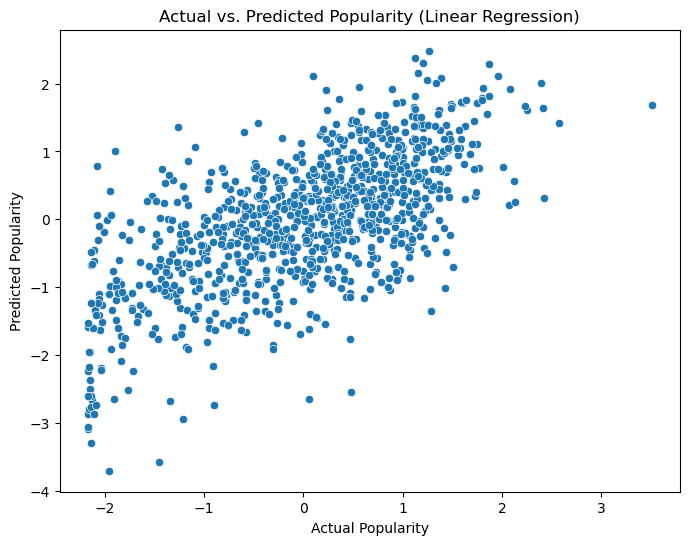

In [149]:
# Scatter plot of actual vs. predicted popularity
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_lr_pred)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Actual vs. Predicted Popularity (Linear Regression)')
plt.show()

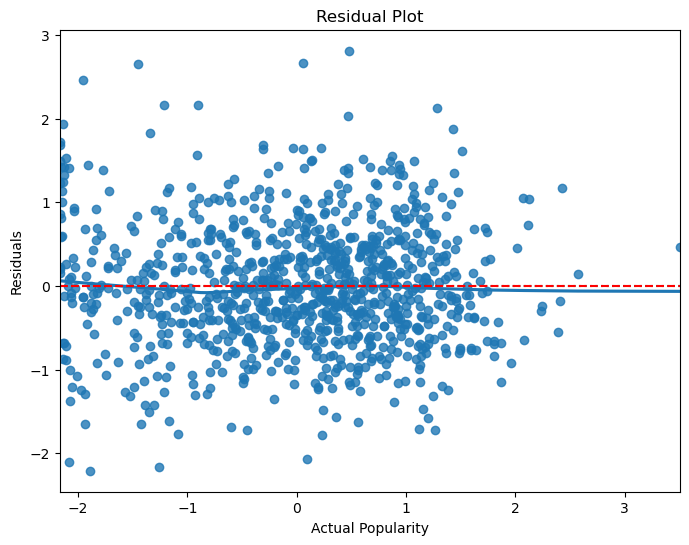

In [150]:
# Residual plot
residuals = y_test - y_lr_pred
plt.figure(figsize=(8, 6))
sns.residplot(x=y_test, y=residuals, lowess=True)
plt.xlabel('Actual Popularity')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()